### Initialization

Load some helpful functions from `math` and `random` standard modules and `matplotlib` and `np` external packages.

In [1]:
from   math import erf, exp, log
from   random import gauss

from   matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

Y = 1       # year
M = 1/12    # month
D = 1/365   # day

### European Call Option

The class below implements Black-Scholes pricing of European Call Option.

You may consider to think how to calculate Delta with Monte-Carlo method.

In [50]:
# Normal CDF
def N(x):
    return (1.0 + erf(x * pow(2.0, -0.5))) / 2.0

class CallOption():
    def __init__(self, K=95.0, r=0.1, si=0.4):
        self.trade = (K, r, si)

    def _d1(self, S, t):
        K, r, si = self.trade
        return 1/si * pow(t,-0.5) * (log(S/K) + (r+0.5*si*si)*t)

    def _d2(self, S, t):
        K, r, si = self.trade
        return 1/si * pow(t,-0.5) * (log(S/K) + (r-0.5*si*si)*t)
    
    def _path(self, s0, t):
        K, r, si = self.trade
        dt  = D
        dt2 = pow(dt, 0.5)
        n   = int(t/dt)

        tj, sj = 0.0, s0
        s = [(tj, sj)]
        for j in range(n):
            sj = sj * exp((r-0.5*si*si)*dt + si*dt2*gauss(0,1))
            tj += dt
            s.append((tj, sj))
        return s
    
    def delta_bs(self, S, t):
        "Black-Scholes theoretical delta, dC/dS"
        K, r, si= self.trade
        if t == 0.0:
            t = 1e-9
        return N(self._d1(S,t))
    
    def price_bs(self, S, t):
        "Black-Scholes theoretical price"
        K, r, si = self.trade
        if t == 0.0:
            return max(0, S-K)
        return S*N(self._d1(S,t)) - K*exp(-r*t)*N(self._d2(S,t))

    def price_mc(self, s0, t, n=500):
        "Black-Scholes Monte-Carlo price"
        K, r, si= self.trade
        
        acc = 0
        for _ in range(n):
            p = self._path(s0, t)
            S = p[-1][1]
            acc += max(0, S-K)
        return exp(-r*t)*acc/n
    
    def delta_mc(self, s0, t, n=100):
        "FAILS: Black-Scholes Monte-Carlo delta"
        ds = 0.0001 # one cent
        c0 = self.price_mc(s0, t, n)
        c1 = self.price_mc(s0 + ds, t, n)
        return (c1-c0)/ds
            
    
    def print(self, s, t):
        print("Price BS = $%.2f" % self.price_bs(s, t))
        print("Delta BS = %.2f" % self.delta_bs(s, t))
        
    def plot(self, val='price_bs', tenors=[0], spot_range=(60, 140, 100)):
        if val == 'price_bs':
            f = self.price_bs
        elif val == 'delta_bs':
            f = self.delta_bs
        elif val == 'price_mc':
            f = self.price_mc
        elif val == 'delta_mc':
            f = self.delta_mc
        else:
            raise Exception ("Function '%s' is not implemented" % val)

        rng = np.linspace(*spot_range)
        for t in tenors:
            # tenors are in months
            points = [(s, f(s, t*M)) for s in rng]
            plt.plot(*zip(*points))
        plt.gca().legend(['%d m' % t for t in tenors])
        plt.grid(True)

### Example

Let's price a call option to buy DESY stocks in 1 year.

In [51]:
desy = CallOption(K=95, r=0.1, si=0.2)
desy.print(90, 1.0)

print('Price MC = $%.2f' % desy.price_mc(90.0, 1.0, 10000))

Price BS = $9.21
Delta BS = 0.63
Price MC = $8.97


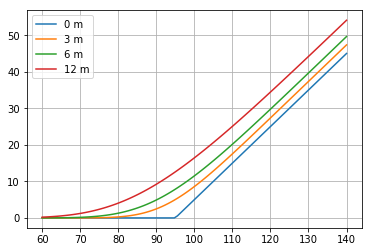

In [60]:
desy.plot('price_bs', tenors=[0,3,6,12], spot_range=[60,140,100])

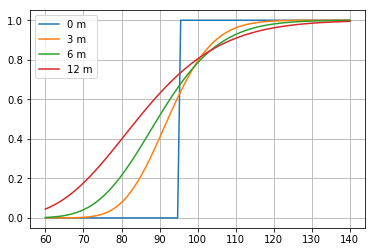

In [61]:
desy.plot('delta_bs', tenors=[0,3,6,12])

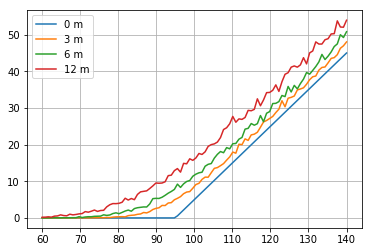

In [43]:
desy.plot('price_mc')